### Import packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import tensorflow_datasets as tfds

### Load cats_vs_dogs dataset by tfds

In [11]:
IMG_SIZE = (224, 224)

In [12]:
def data_augmenter(flip_orientation = "horizontal", rotate_angle = 0.2):
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip(flip_orientation))
    data_augmentation.add(RandomRotation(rotate_angle))

    return data_augmentation

# Resize images to a fixed size
def resize_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.expand_dims(image, axis=0)  # Add a batch dimension
    label = tf.expand_dims(label, axis=0)
    return image, label

def history_plot(history):
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [63]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    "cats_vs_dogs",
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    with_info=True,
    as_supervised=True,
    )

# Apply the resize_image function to the train_ds dataset
train_ds = train_ds.map(resize_image)
valid_ds = valid_ds.map(resize_image)
test_ds  = test_ds.map(resize_image)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

#### Some images

tf.Tensor([1], shape=(1,), dtype=int64)


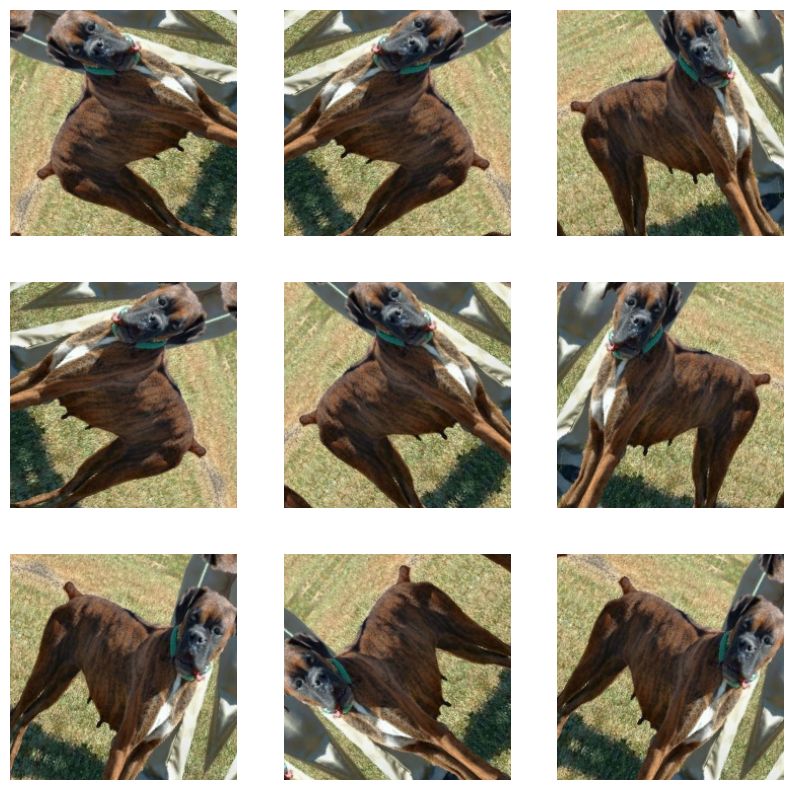

In [62]:
for image, label in train_ds.take(1):
    print(label)
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmenter()(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Transfer Model

#### Define dog_model


In [15]:
def dog_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3, )

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(rate=0.2)(x)
    outputs = tfl.Dense(units=1)(x)

    model = tf.keras.Model(inputs, outputs)

    return model

#### Load and compile model

In [16]:
model = dog_model(IMG_SIZE, data_augmenter())

In [17]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train model

In [18]:
initial_epochs = 5
history = model.fit(train_ds, validation_data=valid_ds, epochs=initial_epochs)

Epoch 1/5
16283/16283 [==============================] - 175s 10ms/step - loss: 0.1214 - accuracy: 0.9555 - val_loss: 0.0327 - val_accuracy: 0.9868
Epoch 2/5
16283/16283 [==============================] - 162s 10ms/step - loss: 0.1173 - accuracy: 0.9625 - val_loss: 0.0400 - val_accuracy: 0.9854
Epoch 3/5
16283/16283 [==============================] - 162s 10ms/step - loss: 0.1222 - accuracy: 0.9616 - val_loss: 0.0439 - val_accuracy: 0.9862
Epoch 4/5
16283/16283 [==============================] - 163s 10ms/step - loss: 0.1238 - accuracy: 0.9628 - val_loss: 0.0463 - val_accuracy: 0.9860
Epoch 5/5
16283/16283 [==============================] - 162s 10ms/step - loss: 0.1252 - accuracy: 0.9630 - val_loss: 0.0372 - val_accuracy: 0.9874


#### Save model weights for reload

In [19]:
model.save("transfered_mobilenetv2_dog_classifier_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Turn off every layer except for some layers to train

In [31]:
def finetune_dog_model(dog_model, finetune_position = 120, learning_rate = 0.001):
    model = dog_model
    model.trainable = True

    for layer in model.layers[:finetune_position]:
        layer.trainable = False

    loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    metrics=["accuracy"]

    model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

    return model

#### Reload transfered model to finetuning

In [32]:
new_model = tf.keras.models.load_model("/content/transfered_mobilenetv2_dog_classifier_model.h5")
finetune_model = finetune_dog_model(new_model)
finetune_history = finetune_model.fit(train_ds,
                         epochs= initial_epochs + 5,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Epoch 5/10
16283/16283 [==============================] - 163s 10ms/step - loss: 0.1160 - accuracy: 0.9625 - val_loss: 0.0372 - val_accuracy: 0.9874
Epoch 6/10
16283/16283 [==============================] - 154s 9ms/step - loss: 0.1142 - accuracy: 0.9635 - val_loss: 0.0372 - val_accuracy: 0.9874
Epoch 7/10
16283/16283 [==============================] - 155s 10ms/step - loss: 0.1181 - accuracy: 0.9637 - val_loss: 0.0372 - val_accuracy: 0.9874
Epoch 8/10
16283/16283 [==============================] - 149s 9ms/step - loss: 0.1091 - accuracy: 0.9654 - val_loss: 0.0372 - val_accuracy: 0.9874
Epoch 9/10
16283/16283 [==============================] - 149s 9ms/step - loss: 0.1175 - accuracy: 0.9618 - val_loss: 0.0372 - val_accuracy: 0.9874
Epoch 10/10
16283/16283 [==============================] - 150s 9ms/step - loss: 0.1149 - accuracy: 0.9635 - val_loss: 0.0372 - val_accuracy: 0.9874


#### Save finetuned model

In [37]:
finetune_model.save("finetuned_mobilenetv2_dog_classifier_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Evaluate the model on test dataset

In [36]:
finetune_model.evaluate(test_ds)
model.evaluate(test_ds)

3489/3489 [==============================] - 26s 7ms/step - loss: 0.0512 - accuracy: 0.9854


[0.051229264587163925, 0.985382616519928]

### Inference example

In [4]:
def preprocess_img_for_inference(img):
    return tf.expand_dims(img, axis=0)

#### Load finetuned model

In [6]:
finetune_model = tf.keras.models.load_model("/content/finetuned_mobilenetv2_dog_classifier_model.h5", compile=False)

#### Inference


1/1 [==============================] - 1s 1s/step
It's a cat!


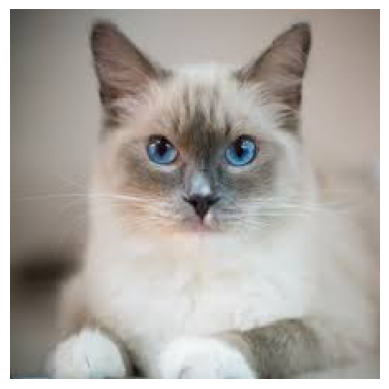

In [7]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = "/content/images.jpg"  # Path to your image
img = image.load_img(img_path, target_size=(224, 224))
processed_img = preprocess_img_for_inference(img)

# Make predictions
predictions = finetune_model.predict(processed_img)

# Interpret predictions
if predictions[0] > 0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()